# Wokflow  **TEST** con zLightGBM

## Inicializacion

In [1]:
# limpio la memoria
Sys.time()
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

[1] "2025-12-01 11:43:38 UTC"

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,658600,35.2,1454564,77.7,1233591,65.9
Vcells,1221988,9.4,8388608,64.0,1975161,15.1


In [2]:
plocal <- list()

# 503
plocal$qcanaritos <- 5L
plocal$min_data_in_leaf <- 200L
plocal$learning_rate <- 1.0
plocal$gradient_bound <- 0.4
plocal$num_iterations <- 64L
plocal$num_leaves <- 99999L
plocal$learning_rate <- 1.0
plocal$feature_fraction <- 0.3
plocal$APO <- 5
plocal$ksemillerio <- 30


In [3]:
PARAM <- list()
PARAM$experimento <- "exp_015"
PARAM$semilla_primigenia <- 611033

PARAM$train_final$future <- c(202107)

PARAM$train_final$training <- c(
  201901, 201902, 201903, 201904, 201905, 201906,
  201907, 201908, 201909, 201910, 201911, 201912,
  202001, 202002, 202003, 202004, 202005,
  202007, 202008, 202009, 202010, 202011, 202012,
  202101, 202102, 202103, 202104, 202105
)

# Este parámetro se usa cuando se hace un undersampling Naive o Exponential
PARAM$train_final$undersampling <- 0.02
# Este parámetro funciona cuando se hace undersampling Volta
PARAM$train_final$undersampling_mix <- 0.75
# Este parámetro frunciona cuando se hace un undersampling exponencial
PARAM$train_final$half_life <- 3 # Cantidad de meses para que el sampling rate decaiga a la mitad, es un proxy intuitivo de la velocidad de decay

# Palancas
quitar_prestamos_personales <- TRUE
quitar_variables_rotas <- FALSE
aplicar_correccion_por_quarter <- TRUE
calcular_tendencias <- FALSE
aplicar_data_drifting_ipc <- FALSE
agregar_randomforest <- FALSE
tipo_de_undersampling <- "NAIVE_2"
quitar_vars_adicionales <- FALSE

In [4]:
setwd("/content/buckets/b1/exp")
experimento_folder <- PARAM$experimento
dir.create(experimento_folder, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento_folder ))

## Preprocesamiento

### Generacion de la clase_ternaria

In [5]:
Sys.time()
require( "data.table" )

# leo el dataset
dataset_c2 <- fread("~/datasets/competencia_02_crudo.csv.gz" )
ultimo_mes <- fread("~/datasets/competencia_03_crudo.csv.gz")


# dataset <- rbind(dataset_c2, ultimo_mes)
dataset <- rbindlist(list(dataset_c2, ultimo_mes), use.names = TRUE, fill = TRUE)

dim(dataset)   # cantidad de filas y columnas
head(dataset, 10)

# calculo el periodo0 consecutivo
dsimple <- dataset[, list(
  "pos" = .I,
  numero_de_cliente,
  periodo0 = as.integer(foto_mes/100)*12 +  foto_mes%%100 )
]


# ordeno
setorder( dsimple, numero_de_cliente, periodo0 )

# calculo topes
periodo_ultimo <- dsimple[, max(periodo0) ]
periodo_anteultimo <- periodo_ultimo - 1


# calculo los leads de orden 1 y 2
dsimple[, c("periodo1", "periodo2") :=
  shift(periodo0, n=1:2, fill=NA, type="lead"),  numero_de_cliente
]

# assign most common class values = "CONTINUA"
dsimple[ periodo0 < periodo_anteultimo, clase_ternaria := "CONTINUA" ]

# calculo BAJA+1
dsimple[ periodo0 < periodo_ultimo &
  ( is.na(periodo1) | periodo0 + 1 < periodo1 ),
  clase_ternaria := "BAJA+1"
]

# calculo BAJA+2
dsimple[ periodo0 < periodo_anteultimo & (periodo0+1 == periodo1 )
  & ( is.na(periodo2) | periodo0 + 2 < periodo2 ),
  clase_ternaria := "BAJA+2"
]

# pego el resultado en el dataset original y grabo
setorder( dsimple, pos )
dataset[, clase_ternaria := dsimple$clase_ternaria ]

rm(dsimple)
gc()
Sys.time()

[1] "2025-12-01 11:43:39 UTC"

Loading required package: data.table



[1] 4883051     154

numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,⋯,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>
249221323,201901,1,0,1,44,69,86.33,14610.01,625.85,⋯,0,8,0.0,-17595.00,0.00,2083,4880.93,5,0,12222.66
249227600,201901,1,0,1,40,254,2096.06,15905.41,287.71,⋯,0,8,0.0,-5828.06,0.00,4810,6750.79,11,0,563.04
249227813,201901,1,0,0,77,156,1071.07,10295.09,864.40,⋯,0,1,0.0,-6092.94,0.00,4739,0.14,2,0,152.49
249231391,201901,1,0,1,55,252,979.98,7670.48,487.01,⋯,0,1,0.0,-24945.96,0.00,4344,12604.18,13,0,1712.58
249244739,201901,1,0,1,64,296,2724.67,36225.32,1865.89,⋯,0,1,0.0,-9551.63,0.00,1227,2043.36,3,0,469.20
249255456,201901,1,0,1,62,296,14301.42,43997.41,8970.82,⋯,0,22,151308.7,-119235.80,1045.02,5604,122057.93,50,0,11190.42
249255747,201901,1,0,1,54,61,11860.08,34676.64,9858.68,⋯,0,1,0.0,-32953.55,0.00,807,24350.69,13,0,3096.72
249257429,201901,1,0,1,59,296,7542.75,34281.62,1960.95,⋯,0,1,0.0,-64438.62,375.57,7604,48761.71,41,0,2087.94
249273979,201901,1,1,1,57,349,11004.27,158228.67,12421.60,⋯,0,8,0.0,-71884.60,192.00,8427,65399.33,46,0,5501.37


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,771318,41.2,1454564,77.7,1454564,77.7
Vcells,1301361194,9928.6,1777924307,13564.5,1449989853,11062.6


[1] "2025-12-01 11:44:18 UTC"

In [6]:
setorder( dataset, foto_mes, clase_ternaria, numero_de_cliente)
dataset[, .N, list(foto_mes, clase_ternaria)]

foto_mes,clase_ternaria,N
<int>,<chr>,<int>
201901,BAJA+1,645
201901,BAJA+2,729
201901,CONTINUA,122899
201902,BAJA+1,733
201902,BAJA+2,707
201902,CONTINUA,123961
201903,BAJA+1,708
201903,BAJA+2,751
201903,CONTINUA,124508


### Eliminacion de Features

Completar a gusto LUEGO de realizar un analisis exploratorio de datos.
<br> No necesariamente en esta Segunda Competencia conviele eliminar los mismos campos que en la Primera ...

In [7]:
if (quitar_prestamos_personales) {
    cat("Quito prestamos personales\n")
    # Salsa Magica para 202106
    dataset[, mprestamos_personales := NULL ]
    dataset[, cprestamos_personales := NULL ]
} else {
cat("No quito prestamos personales\n")
}

Quito prestamos personales


In [8]:
if (quitar_vars_adicionales) {
    cat("Quitando variables adicionales")
    dataset[, mcuentas_saldo := NULL]
} else {
    cat("No quito variables adicionales")
}


No quito variables adicionales

### Eliminación de Variables rotas
Estas son variables que tienen todos los valores en cero en un determinado mes

In [9]:
if (quitar_variables_rotas) {
    
    cat("Detectando y Quitando variables rotas\n")
    # asumimos que `dataset` ya es un data.table y tiene la columna foto_mes

    # 1) columnas numéricas candidatas (excluimos foto_mes)
    cols_num <- setdiff(names(dataset)[sapply(dataset, is.numeric)], "foto_mes")

    # 2) detectar, por mes, qué columnas están TODAS en 0
    # isTRUE(all(v == 0)) devuelve TRUE solo si no hay NAs y todo es 0; si hay NAs -> FALSE
    flag_wide <- dataset[
    , lapply(.SD, function(v) isTRUE(all(v == 0))), by = .(foto_mes), .SDcols = cols_num
    ]

    # Pasar a largo y quedarnos con las que son TRUE (rotas)
    rotas <- melt(
    flag_wide, id.vars = "foto_mes",
    variable.name = "variable", value.name = "all_zero"
    )[all_zero == TRUE, .(foto_mes, variable)]

    # 3) reemplazar por NA esas variables en esos meses (respetando tipo de columna)
    if (nrow(rotas) > 0) {
    for (k in seq_len(nrow(rotas))) {
        col <- rotas$variable[k]
        mes <- rotas$foto_mes[k]
        na_val <- if (is.integer(dataset[[col]])) NA_integer_ else NA_real_
        set(dataset, i = which(dataset$foto_mes == mes), j = col, value = na_val)
        }
    }

    # `rotas` queda como la lista de variables detectadas por mes
    rotas[]
} else {
    cat("No quito variables rotas\n")
}

No quito variables rotas


### Data Drifting

Se debe corregir el drifting natural que ocurre en loa datos, en particular los datos monetarios que se vieron fuertemente afectados por una alta inflación
<br> Posibles métodos son:
* No hacer absolutamente nada
* Ajuste de valores monetarios por indices del tipo :
   * IPC  Indice de Precios al Consumidor
   * Dolar Oficial
   * Dolar Blue
   * UVA  Unidad de Valor Adquisitivo

a este codigo de Data Drifting lo debera escribir usted

In [10]:
# Tabla de IPC tomada de: https://www.indec.gob.ar/indec/web/Nivel4-Tema-3-5-31
tabla_ipc <- data.table(
    foto_mes = c(201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908, 201909, 
    201910, 201911, 201912, 202001, 202002, 202003, 202004, 202005, 202006, 
    202007, 202008, 202009, 202010, 202011, 202012, 202101, 202102, 202103, 
    202104, 202105, 202106),
    ipc_nucleo = c(3.0, 3.9, 4.6, 3.8, 3.2, 2.7, 2.1, 4.6, 6.4, 3.8, 4.0, 3.7, 2.4, 2.4, 
    3.1, 1.7, 1.6, 2.3, 2.5, 3.0, 2.3, 3.5, 3.9, 4.9, 3.9, 4.1, 4.5, 4.6, 
    3.5, 3.6)
)

variables_a_indexar <- c("mrentabilidad", "mrentabilidad_annual", "mcomisiones",
"mactivos_margen","mpasivos_margen","mcuenta_corriente","mcaja_ahorro",
"mcaja_ahorro_adicional","mcaja_ahorro_dolares","mautoservicio",
"mtarjeta_visa_consumo","mtarjeta_master_consumo","mprestamos_prendarios",
"mprestamos_hipotecarios","mplazo_fijo_pesos","minversion1_pesos","minversion2",
"mpayroll","mpayroll2","mcuenta_debitos_automaticos","mttarjeta_visa_debitos_automaticos",
"mttarjeta_master_debitos_automaticos","mpagodeservicios","mpagomiscuentas",
"mcajeros_propios_descuentos","mtarjeta_visa_descuentos","mtarjeta_master_descuentos",
"mcomisiones_mantenimiento","mcomisiones_otras","mforex_buy","mforex_sell",
"mtransferencias_recibidas","mtransferencias_emitidas","mextraccion_autoservicio",
"mcheques_depositados","mcheques_emitidos","mcheques_depositados_rechazados",
"mcheques_emitidos_rechazados","matm","matm_other","Master_mfinanciacion_limite",
"Master_mconsumospesos","Master_mlimitecompra","Master_madelantopesos","Master_mpagado",
"Master_mpagospesos","Master_mconsumototal","Master_mpagominimo",
"Visa_mfinanciacion_limite","Visa_msaldototal","Visa_msaldopesos",
"Visa_mconsumospesos","Visa_mlimitecompra","Visa_madelantopesos",
"Visa_mpagado","Visa_mpagospesos","Visa_mconsumototal","Visa_mpagominimo")

# Por como está hecha la función de data drifting, habría que agregar las dos
# variables de abajo en la lista de variables a indexar directamente
if (!quitar_prestamos_personales) {
    variables_a_indexar <- c(variables_a_indexar, "mprestamos_personales")
}

if (!quitar_vars_adicionales) {
    variables_a_indexar <- c(variables_a_indexar,  "mcuentas_saldo")
}


In [11]:
if (aplicar_data_drifting_ipc) {
    cat("Aplicando la corrección de Data Drifting por IPC \n")
    # --- Supuestos ---
    # dataset: data.table con columna foto_mes (YYYYMM, numérico/integer)
    # tabla_ipc: data.table con columnas foto_mes (YYYYMM) e IPC (% mensual vs mes anterior)
    # variables_a_indexar: character vector con nombres de columnas numéricas a deflactar
    # objetivo: expresar montos en moneda constante de 201901

    # 1) Definir mes base
    mes_base <- 201901L

    # 2) Asegurar orden y calcular factor acumulado de precios (base = 1 en 201901)
    #    IPC está en % mensual -> factor mensual = 1 + IPC/100
    #    factor_acum en 201901 = 1; luego se compone multiplicando mes a mes
    ipc <- copy(tabla_ipc)
    setorder(ipc, foto_mes)

    ipc[, factor_mes := 1 + ipc_nucleo/100]
    ipc[foto_mes == mes_base, factor_mes := 1]                 # base = 1 (ignoramos su IPC respecto a dic-2018)
    ipc[, factor_acum := cumprod(factor_mes)]

    # 3) Unir factor al dataset
    #    (queda una columna 'factor_acum' en dataset para cada fila/mes)
    dataset[ipc[, .(foto_mes, factor_acum)], on = "foto_mes", factor_acum := i.factor_acum]

    # 4) Crear columnas ajustadas a moneda constante 201901
    #    monto_const = monto_nominal / factor_acum
    #    (si te interesara llevar a moneda de otro mes base, multiplicás por factor_base/ factor_mes)
    sufijo <- "_const201901"

    for (col in variables_a_indexar) {
        if (col %in% names(dataset)) {
            cat("Corrigiendo columna: ", col, "\n")
            dataset[, (col) := get(col) / factor_acum]
        } else {
        cat("⚠️  La columna no existe en dataset: ", col, "\n")
        }
    }

    # 5) limpiar columna auxiliar
    dataset[, factor_acum := NULL]
    cat("✔️  Corrección por IPC aplicada a", length(variables_a_indexar), "columnas.\n")
    

} else {
    cat("Pasando por alto la corrección de Data Drifting por IPC \n")
}

Pasando por alto la corrección de Data Drifting por IPC 


### Feature Engineering Intra-Mes

Crear variables nuevas a partir de las existentes dentro del mismo registro, **sin** ir a buscar información histórica.
<br> El siguiente código es un mínimo ejemplo, agregar nuevos features a gusto

In [12]:
if (aplicar_correccion_por_quarter) {
    cat("Aplicando corrección por quarter\n")
    # el mes 1,2, ..12 , podria servir para detectar estacionalidad
    dataset[, kmes := foto_mes %% 100]

    # creo un ctr_quarter que tenga en cuenta cuando
    # los clientes hace 3 menos meses que estan
    # ya que seria injusto considerar las transacciones medidas en menor tiempo
    dataset[, ctrx_quarter_normalizado := as.numeric(ctrx_quarter) ]
    dataset[cliente_antiguedad == 1, ctrx_quarter_normalizado := ctrx_quarter * 5.0]
    dataset[cliente_antiguedad == 2, ctrx_quarter_normalizado := ctrx_quarter * 2.0]
    dataset[cliente_antiguedad == 3, ctrx_quarter_normalizado := ctrx_quarter * 1.2]

    # variable extraida de una tesis de maestria de Irlanda, se perdió el link
    dataset[, mpayroll_sobre_edad := mpayroll / cliente_edad]
} else {
    cat("Salteando la corrección por quarter\n")
}

Sys.time()

Aplicando corrección por quarter


[1] "2025-12-01 11:44:19 UTC"

### Feature Engineering Historico

In [13]:
if( !require("Rcpp")) install.packages("Rcpp", repos = "http://cran.us.r-project.org")
require("Rcpp")

Loading required package: Rcpp



In [14]:
# se calculan para los 6 meses previos el minimo, maximo y
#  tendencia calculada con cuadrados minimos
# la formula de calculo de la tendencia puede verse en
#  https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/10%3A_Correlation_and_Regression/10.04%3A_The_Least_Squares_Regression_Line
# para la maxíma velocidad esta funcion esta escrita en lenguaje C,
# y no en la porqueria de R o Python

cppFunction("NumericVector fhistC(NumericVector pcolumna, IntegerVector pdesde )
{
  /* Aqui se cargan los valores para la regresion */
  double  x[100] ;
  double  y[100] ;

  int n = pcolumna.size();
  NumericVector out( 5*n );

  for(int i = 0; i < n; i++)
  {
    //lag
    if( pdesde[i]-1 < i )  out[ i + 4*n ]  =  pcolumna[i-1] ;
    else                   out[ i + 4*n ]  =  NA_REAL ;


    int  libre    = 0 ;
    int  xvalor   = 1 ;

    for( int j= pdesde[i]-1;  j<=i; j++ )
    {
       double a = pcolumna[j] ;

       if( !R_IsNA( a ) )
       {
          y[ libre ]= a ;
          x[ libre ]= xvalor ;
          libre++ ;
       }

       xvalor++ ;
    }

    /* Si hay al menos dos valores */
    if( libre > 1 )
    {
      double  xsum  = x[0] ;
      double  ysum  = y[0] ;
      double  xysum = xsum * ysum ;
      double  xxsum = xsum * xsum ;
      double  vmin  = y[0] ;
      double  vmax  = y[0] ;

      for( int h=1; h<libre; h++)
      {
        xsum  += x[h] ;
        ysum  += y[h] ;
        xysum += x[h]*y[h] ;
        xxsum += x[h]*x[h] ;

        if( y[h] < vmin )  vmin = y[h] ;
        if( y[h] > vmax )  vmax = y[h] ;
      }

      out[ i ]  =  (libre*xysum - xsum*ysum)/(libre*xxsum -xsum*xsum) ;
      out[ i + n ]    =  vmin ;
      out[ i + 2*n ]  =  vmax ;
      out[ i + 3*n ]  =  ysum / libre ;
    }
    else
    {
      out[ i       ]  =  NA_REAL ;
      out[ i + n   ]  =  NA_REAL ;
      out[ i + 2*n ]  =  NA_REAL ;
      out[ i + 3*n ]  =  NA_REAL ;
    }
  }

  return  out;
}")

In [15]:
# calcula la tendencia de las variables cols de los ultimos 6 meses
# la tendencia es la pendiente de la recta que ajusta por cuadrados minimos
# La funcionalidad de ratioavg es autoria de  Daiana Sparta,  UAustral  2021

TendenciaYmuchomas <- function(
    dataset, cols, ventana = 6, tendencia = TRUE,
    minimo = TRUE, maximo = TRUE, promedio = TRUE,
    ratioavg = FALSE, ratiomax = FALSE) {
  gc(verbose= FALSE)
  # Esta es la cantidad de meses que utilizo para la historia
  ventana_regresion <- ventana

  last <- nrow(dataset)

  # creo el vector_desde que indica cada ventana
  # de esta forma se acelera el procesamiento ya que lo hago una sola vez
  vector_ids <- dataset[ , numero_de_cliente ]

  vector_desde <- seq(
    -ventana_regresion + 2,
    nrow(dataset) - ventana_regresion + 1
  )

  vector_desde[1:ventana_regresion] <- 1

  for (i in 2:last) {
    if (vector_ids[i - 1] != vector_ids[i]) {
      vector_desde[i] <- i
    }
  }
  for (i in 2:last) {
    if (vector_desde[i] < vector_desde[i - 1]) {
      vector_desde[i] <- vector_desde[i - 1]
    }
  }

  for (campo in cols) {
    nueva_col <- fhistC(dataset[, get(campo)], vector_desde)

    if (tendencia) {
      dataset[, paste0(campo, "_tend", ventana) :=
        nueva_col[(0 * last + 1):(1 * last)]]
    }

    if (minimo) {
      dataset[, paste0(campo, "_min", ventana) :=
        nueva_col[(1 * last + 1):(2 * last)]]
    }

    if (maximo) {
      dataset[, paste0(campo, "_max", ventana) :=
        nueva_col[(2 * last + 1):(3 * last)]]
    }

    if (promedio) {
      dataset[, paste0(campo, "_avg", ventana) :=
        nueva_col[(3 * last + 1):(4 * last)]]
    }

    if (ratioavg) {
      dataset[, paste0(campo, "_ratioavg", ventana) :=
        get(campo) / nueva_col[(3 * last + 1):(4 * last)]]
    }

    if (ratiomax) {
      dataset[, paste0(campo, "_ratiomax", ventana) :=
        get(campo) / nueva_col[(2 * last + 1):(3 * last)]]
    }
  }
}

In [16]:
# Feature Engineering Historico
# Creacion de LAGs: Esto se hace siempre
setorder(dataset, numero_de_cliente, foto_mes)

# todo es lagueable, menos la primary key y la clase
cols_lagueables <- copy( setdiff(
  colnames(dataset),
  c("numero_de_cliente", "foto_mes", "clase_ternaria")
))

# https://rdrr.io/cran/data.table/man/shift.html

# lags de orden 1
dataset[,
  paste0(cols_lagueables, "_lag1") := shift(.SD, 1, NA, "lag"),
  by= numero_de_cliente,
  .SDcols= cols_lagueables
]

# lags de orden 2
dataset[,
  paste0(cols_lagueables, "_lag2") := shift(.SD, 2, NA, "lag"),
  by= numero_de_cliente,
  .SDcols= cols_lagueables
]
# lags de orden 3
dataset[,
  paste0(cols_lagueables, "_lag3") := shift(.SD, 3, NA, "lag"),
  by= numero_de_cliente,
  .SDcols= cols_lagueables
]

# lags de orden 6
dataset[,
  paste0(cols_lagueables, "_lag6") := shift(.SD, 6, NA, "lag"),
  by= numero_de_cliente,
  .SDcols= cols_lagueables
]
# agrego los delta lags y Ratio Lags
for (vcol in cols_lagueables)
{
  dataset[, paste0(vcol, "_delta1") := get(vcol) - get(paste0(vcol, "_lag1"))]
  dataset[, paste0(vcol, "_ratio1") :=
    fifelse(get(paste0(vcol, "_lag1")) == 0,
            NA_real_,
            get(vcol) / get(paste0(vcol, "_lag1")))]
  dataset[, paste0(vcol, "_ratio2") :=
        fifelse(get(paste0(vcol, "_lag2")) == 0,
                NA_real_,
                get(vcol) / get(paste0(vcol, "_lag2")))]
  dataset[, paste0(vcol, "_ratio3") :=
        fifelse(get(paste0(vcol, "_lag3")) == 0,
                NA_real_,
                get(vcol) / get(paste0(vcol, "_lag3")))]
  dataset[, paste0(vcol, "_ratio6") :=
        fifelse(get(paste0(vcol, "_lag6")) == 0,
                NA_real_,
                get(vcol) / get(paste0(vcol, "_lag3")))]
  dataset[, paste0(vcol, "_delta2") := get(vcol) - get(paste0(vcol, "_lag2"))]
  dataset[, paste0(vcol, "_delta3") := get(vcol) - get(paste0(vcol, "_lag3"))]
  dataset[, paste0(vcol, "_delta6") := get(vcol) - get(paste0(vcol, "_lag6"))]  
}
gc(full=TRUE, verbose=FALSE) # garbage collection
Sys.time()

[1] "2025-12-01 11:50:28 UTC"

In [17]:
# parametros de Feature Engineering Historico de Tendencias
PARAM$FE_hist$Tendencias$run <- FALSE
PARAM$FE_hist$Tendencias$ventana <- 6
PARAM$FE_hist$Tendencias$tendencia <- FALSE
PARAM$FE_hist$Tendencias$minimo <- FALSE
PARAM$FE_hist$Tendencias$maximo <- FALSE
PARAM$FE_hist$Tendencias$promedio <- TRUE
PARAM$FE_hist$Tendencias$ratioavg <- FALSE
PARAM$FE_hist$Tendencias$ratiomax <- FALSE

In [18]:
# aqui se agregan las tendencias de los ultimos 6 meses
if (calcular_tendencias) {
    cat("Ejecutando cálculo de tendencias\n")
    cols_lagueables <- intersect(cols_lagueables, colnames(dataset))
    setorder(dataset, numero_de_cliente, foto_mes)

    if( PARAM$FE_hist$Tendencias$run) {
        TendenciaYmuchomas(dataset,
        cols = cols_lagueables,
        ventana = PARAM$FE_hist$Tendencias$ventana, # 6 meses de historia
        tendencia = PARAM$FE_hist$Tendencias$tendencia,
        minimo = PARAM$FE_hist$Tendencias$minimo,
        maximo = PARAM$FE_hist$Tendencias$maximo,
        promedio = PARAM$FE_hist$Tendencias$promedio,
        ratioavg = PARAM$FE_hist$Tendencias$ratioavg,
        ratiomax = PARAM$FE_hist$Tendencias$ratiomax
      )
    }
} else cat("Pasando por alto el cálculo de tendencias\n")
gc(full=TRUE, verbose=FALSE) # garbage collection
ncol(dataset)
Sys.time()

Pasando por alto el cálculo de tendencias


[1] 1992

[1] "2025-12-01 11:50:28 UTC"

### Feature Engineering a partir de hojas de RF
Creamos features a partir de la pertenencia a hojas de un RF pre-construido.

In [19]:
if( !require("lightgbm")) install.packages("lightgbm")
require("lightgbm")

AgregaVarRandomForest <- function() {

  cat( "inicio AgregaVarRandomForest()\n")
  gc(verbose= FALSE)
  dataset[, clase01 := 0L ]
  dataset[ clase_ternaria %in% c( "BAJA+2", "BAJA+1"),
      clase01 := 1L ]

  campos_buenos <- setdiff(
    colnames(dataset),
    c( "clase_ternaria", "clase01")
  )

  dataset[, entrenamiento :=
    as.integer( foto_mes %in% PARAM$FE_rf$train$training )]

  dtrain <- lgb.Dataset(
    data = data.matrix(dataset[entrenamiento == TRUE, campos_buenos, with = FALSE]),
    label = dataset[entrenamiento == TRUE, clase01],
    free_raw_data = FALSE
  )

  modelo <- lgb.train(
     data = dtrain,
     param = PARAM$FE_rf$lgb_param,
     verbose = -100
  )

  cat( "Fin construccion RandomForest\n" )
  # grabo el modelo, achivo .model
  lgb.save(modelo, file="modelo.model" )

  qarbolitos <- copy(PARAM$FE_rf$lgb_param$num_iterations)

  periodos <- dataset[ , unique( foto_mes ) ]

  for( periodo in  periodos )
  {
    cat( "periodo = ", periodo, "\n" )
    datamatrix <- data.matrix(dataset[ foto_mes== periodo, campos_buenos, with = FALSE])

    cat( "Inicio prediccion\n" )
    prediccion <- predict(
        modelo,
        datamatrix,
        type = "leaf"
    )
    cat( "Fin prediccion\n" )

    for( arbolito in 1:qarbolitos )
    {
       cat( arbolito, " " )
       hojas_arbol <- unique(prediccion[ , arbolito])

       for (pos in 1:length(hojas_arbol)) {
         # el numero de nodo de la hoja, estan salteados
         nodo_id <- hojas_arbol[pos]
         dataset[ foto_mes== periodo, paste0(
            "rf_", sprintf("%03d", arbolito),
             "_", sprintf("%03d", nodo_id)
          ) :=  as.integer( nodo_id == prediccion[ , arbolito]) ]

       }

       rm( hojas_arbol )
    }
    cat( "\n" )

    rm( prediccion )
    rm( datamatrix )
    gc(verbose= FALSE)
  }

  gc(verbose= FALSE)

  # borro clase01 , no debe ensuciar el dataset
  dataset[ , clase01 := NULL ]

}

Loading required package: lightgbm



In [20]:
# Parametros de Feature Engineering  a partir de hojas de Random Forest

# Estos CUATRO parametros son los que se deben modificar
# ToDo: Encontrar variantes para estos parámetros
PARAM$FE_rf$arbolitos= 20
PARAM$FE_rf$hojas_por_arbol= 16
PARAM$FE_rf$datos_por_hoja= 100
PARAM$FE_rf$mtry_ratio= 0.2

# Estos son quasi fijos
PARAM$FE_rf$train$training <- c( 202101, 202102, 202103)

# Estos TAMBIEN son quasi fijos
PARAM$FE_rf$lgb_param <-list(
    # parametros que se pueden cambiar
    num_iterations = PARAM$FE_rf$arbolitos,
    num_leaves  = PARAM$FE_rf$hojas_por_arbol,
    min_data_in_leaf = PARAM$FE_rf$datos_por_hoja,
    feature_fraction_bynode  = PARAM$FE_rf$mtry_ratio,

    # para que LightGBM emule Random Forest
    boosting = "rf",
    bagging_fraction = ( 1.0 - 1.0/exp(1.0) ),
    bagging_freq = 1.0,
    feature_fraction = 1.0,

    # genericos de LightGBM
    max_bin = 31L,
    objective = "binary",
    first_metric_only = TRUE,
    boost_from_average = TRUE,
    feature_pre_filter = FALSE,
    force_row_wise = TRUE,
    verbosity = -100,
    max_depth = -1L,
    min_gain_to_split = 0.0,
    min_sum_hessian_in_leaf = 0.001,
    lambda_l1 = 0.0,
    lambda_l2 = 0.0,

    pos_bagging_fraction = 1.0,
    neg_bagging_fraction = 1.0,
    is_unbalance = FALSE,
    scale_pos_weight = 1.0,

    drop_rate = 0.1,
    max_drop = 50,
    skip_drop = 0.5,

    extra_trees = FALSE
  )


In [21]:
# Feature Engineering agregando variables de Random Forest
#  aqui es donde se hace el trabajo
if (agregar_randomforest) {
    cat("Agregando Variables Random Forest \n")
    AgregaVarRandomForest()
    ncol(dataset)
    colnames(dataset)
} else {
    cat("Pasando por alto el agregado de Variables Random Forest \n")
}
Sys.time()

Pasando por alto el agregado de Variables Random Forest 


[1] "2025-12-01 11:50:29 UTC"

## Modelado

No hay modelado, no se hace optimizacion de hiperparametros.

## Produccion

Las decisiones que se toman para la construccion del modelo final son:
* Los positvos son  POS={"BAJA+1", "BAJA+2"}, esta es una meticulosa decisión.
* Se entrena en los treinta meses del intervalo [201901, 202104]
* Se realiza undersampling al 5%
* Se utilizan los hiperparámetros optimos encontrados en la Bayesian Optimization
   * Se escala min_data_in_leaf

### Final Training Strategy

In [22]:
# se filtran los meses donde se entrena el modelo final
dataset_train_final <- dataset[foto_mes %in% PARAM$train_final$training]

In [23]:
# canaritos
PARAM$train_final$lgbm$qcanaritos <- plocal$qcanaritos

cols0 <- copy(colnames(dataset_train_final))
filas <- nrow(dataset_train_final)

if( PARAM$train_final$lgbm$qcanaritos > 0 ) {
  for( i in seq(PARAM$train_final$lgbm$qcanaritos) ){
    dataset_train_final[, paste0("canarito_",i) := runif( filas) ]
  }

  # las columnas canaritos mandatoriamente van al comienzo del dataset
  cols_canaritos <- copy( setdiff( colnames(dataset_train_final), cols0 ) )
  setcolorder( dataset_train_final, c( cols_canaritos, cols0 ) )
}

Sys.time()

[1] "2025-12-01 11:51:12 UTC"

#### Registros cambio las proporciones de POS/NEG

In [24]:
library(data.table)
clientwise_undersampling_by_mix <- function(dataset_in, mix_proportion, semilla) {
    # Mix proportion: Cuantas veces más filas de clientes sin baja hay con respecto a filas de clientes con baja
    # Dado un punto de partida de filas pertenecientes a clientes con baja, cuantas veces más filas de 
    # clientes sin baja habrá. Ej, si mix_proportion == 1 entonces hay una mezcla en partes iguales: 1:1
    # Si mix_proportion == 2 entonces hay una mezcla en 1:2 de con baja vs sin baja

    dataset <- copy(dataset_in)

    # Semilla para reproducibilidad de la selección aleatoria de clientes "negativos"
    set.seed(semilla, kind = "L'Ecuyer-CMRG")

    # --- 1) Resumen por cliente: si tiene baja y cuántas filas aporta
    clientes <- dataset[
    , .(
        tiene_baja = any(clase_ternaria %in% c("BAJA+1", "BAJA+2")),
        n_rows     = .N
      ),
    by = numero_de_cliente
    ]

  
    # Separar clientes positivos (baja) y negativos (no baja) -> éstas son dos data tables
    pos <- clientes[tiene_baja == TRUE]
    neg <- clientes[tiene_baja == FALSE]

    cuenta_filas_clientes_con_baja <- nrow(dataset[numero_de_cliente %in% pos$numero_de_cliente])
    cuenta_filas_clientes_sin_baja <- nrow(dataset[numero_de_cliente %in% neg$numero_de_cliente])
    cuenta_filas_totales <- nrow(dataset)
    
    cat("Numero de Filas pertenecientes a clientes con baja: ", cuenta_filas_clientes_con_baja, "\n")
    cat("Numero de Filas pertenecientes a clientes sin baja: ", cuenta_filas_clientes_sin_baja, "\n")


    undersampling_sin_baja = mix_proportion * (cuenta_filas_clientes_con_baja / cuenta_filas_totales)
    cat("Proporción de filas de clientes con baja: ", cuenta_filas_clientes_con_baja / cuenta_filas_totales, "\n")
    cat("Proporción de filas esperada en clientes sin baja: ", undersampling_sin_baja, "\n") 

    # target_rows  <- as.integer(round(undersampling_sin_baja * nrow(dataset[numero_de_cliente %in% neg$numero_de_cliente])))
    target_rows  <- as.integer(round(mix_proportion * (cuenta_filas_clientes_con_baja)))
    cat("Filas objetivo para clientes con baja: ", target_rows, "\n")
    cat("Filas objetivo totales: ", target_rows + cuenta_filas_clientes_con_baja, "\n")  

    # Incluyo todos los BAJA
    clientes_incluir <- pos[, numero_de_cliente]

    # --- 4) Necesitamos sumar filas de clientes SIN baja hasta acercarnos al objetivo
    ## 
    # remaining_needed <- target_rows

    # Barajar clientes negativos y acumular sus tamaños
    neg[, rand := runif(.N)]
    setorder(neg, rand)
    neg[, cum_rows := cumsum(n_rows)]

    # Índice donde superamos (o alcanzamos) lo necesario
    #k <- neg[, which(cum_rows >= remaining_needed)[1]]
     k <- neg[, which(cum_rows >= target_rows)[1]]
    cat("Filas acumuladas en corte de undersampling candidato: ", neg$cum_rows[k], "\n")
    
    # Elegimos entre tomar hasta k-1 o hasta k, lo que quede más cerca del objetivo
    cum_before <- neg$cum_rows[k - 1L]
    cum_after  <- neg$cum_rows[k]
    if (abs(cum_after - target_rows) <= abs(cum_before - target_rows)) {
        neg_sel <- neg[1:k,  numero_de_cliente]
    } else {
        neg_sel <- neg[1:(k-1L), numero_de_cliente]
    }
    clientes_incluir <- c(pos[, numero_de_cliente], neg_sel)
  
    # --- 5) Marcar training por cliente (incluyendo/excluyendo clientes completos)
    dataset[, training := 0L]
    dataset[numero_de_cliente %in% clientes_incluir, training := 1L]
  
    # --- 6) (Opcional) Reporte final
    #achieved <- nrow(dataset[clase_ternaria == "CONTINUA" & training == 1])/ nrow(dataset[clase_ternaria == "CONTINUA"])
    achieved <- nrow(dataset[numero_de_cliente %in% neg$numero_de_cliente & training == 1])/cuenta_filas_totales  
    message(sprintf(
    "Undersampling objetivo de clientes sin baja: %.4f | Alcanzado (sobre filas): %.4f",
    undersampling_sin_baja, achieved
  ))
    cat("Undersampling global alcanzado: ", nrow(dataset[training == 1])/nrow(dataset), "\n")
    cat("Proporción de clientes BAJA : clientes CONTINUA", nrow(dataset[numero_de_cliente %in% pos$numero_de_cliente & training == 1]) / 
        nrow(dataset[numero_de_cliente %in% neg$numero_de_cliente & training == 1]), "\n")

  return(dataset)
}


In [25]:
exponential_sampler <- function(
  df,
  target_col = "clase_ternaria",
  sampling_target = 0.02,
  half_life = 6,
  seed = NULL
) {

  # Confirmar que existe foto_mes
  if (!"foto_mes" %in% names(df)) {
    stop("El dataset debe tener la columna 'foto_mes' para aplicar sampling por mes.")
  }

  # Filtro CONTINUA
  df_cont <- df[df[[target_col]] == "CONTINUA", ]
  if (nrow(df_cont) == 0) stop("No hay filas CONTINUA.")

  # Ordenar por recencia
  df_cont <- df_cont[order(-df_cont$foto_mes), ]

  # Meses únicos más recientes primero
  meses <- sort(unique(df_cont$foto_mes), decreasing = TRUE)
  n_meses <- length(meses)

  # t por mes: 0 = más reciente
  t_meses <- 0:(n_meses - 1)

  # Parámetro de la exponencial
  b <- log(2) / half_life

  # Decaimiento teórico
  decay_meses <- exp(-b * t_meses)

  # Buscar 'a' con uniroot para que mean(pmin(a*decay, 1)) = sampling_target
  f_objetivo <- function(a) {
    mean(pmin(a * decay_meses, 1)) - sampling_target
  }

  a <- uniroot(
    f = f_objetivo,
    interval = c(0, 1e6),
    extendInt = "yes"
  )$root

  # Probabilidades por mes
  probs_meses <- pmin(a * decay_meses, 1)

  # Crear un mapping mes → prob
  prob_map <- setNames(probs_meses, meses)

  # Asignar probabilidad por mes a df
  df$sampling_prob <- prob_map[as.character(df$foto_mes)]

  # Sampling real por si se pide reproducibilidad
  if (!is.null(seed)) {
    set.seed(seed)
    df$sampled_flag <- rbinom(nrow(df), 1, df$sampling_prob) == 1
  } else {
    df$sampled_flag <- NA
  }

  # Sampling real para CONTINUA
  real_sampling <- mean(df$sampling_prob[df[[target_col]] == "CONTINUA"])
  real_applied <- if (!is.null(seed)) {
    mean(df$sampled_flag[df[[target_col]] == "CONTINUA"])
  } else {
    NA
  }

  # Gráfico solo por mes
  plot(
    t_meses, probs_meses, type = "b",
    main = "Curva de Sampling Exponencial (por mes)",
    xlab = "t (0 = mes más reciente)",
    ylab = "Probabilidad",
    pch = 19
  )

  # Prints explicativos
  cat("=== Parámetros de la curva ===\n")
  cat("a =", a, "\n")
  cat("b =", b, "(half-life =", half_life, ")\n")
  cat("Sampling objetivo        :", sampling_target, "\n")
  cat("Sampling REAL estimado   :", real_sampling, "\n")
  if (!is.null(seed)) {
    cat("Sampling REAL aplicado   :", real_applied, "\n")
  }

  return(list(
    df = df,
    probs_meses = probs_meses,
    meses = meses,
    a = a,
    b = b
  ))
}


In [26]:
contar_filas <- function(dataset_in) {
    cant_clientes <- uniqueN(dataset_in$numero_de_cliente)
    cant_filas <- nrow(dataset_in)
    cat("Clientes únicos en dataset completo:", cant_clientes, "\n")
    cat("Filas totales en dataset completo:", cant_filas, "\n")
    cat("Clientes únicos en dataset de entrenamiento:", uniqueN(dataset_in[training == 1, numero_de_cliente]), "\n")
    cat("Filas totales en dataset de entrenamiento:", nrow(dataset_in[training == 1]), "\n")  
    cat("Filas CONTINUA en dataset original: ", nrow(dataset_in[clase_ternaria == "CONTINUA"]), "\n")
    cat("Filas CONTINUA en dataset training: ", nrow(dataset_in[training == 1 & clase_ternaria == "CONTINUA"]), "\n")
    cat("Undersampling Global en filas CONTINUA: ", nrow(dataset_in[training == 1 & clase_ternaria == "CONTINUA"]) / 
        nrow(dataset_in[clase_ternaria == "CONTINUA"]), "\n")
    cat("Filas BAJA en dataset original: ", nrow(dataset_in[clase_ternaria %in% c("BAJA+1", "BAJA+2")]), "\n")
    cat("Filas BAJA en dataset training: ", nrow(dataset_in[training == 1 & clase_ternaria %in% c("BAJA+1", "BAJA+2")]), "\n")
    cat("Undersampling Global en filas BAJA: ", nrow(dataset_in[training == 1 & clase_ternaria %in% c("BAJA+1", "BAJA+2")]) / 
    nrow(dataset_in[clase_ternaria %in% c("BAJA+1", "BAJA+2")]), "\n")
}


In [27]:
# Undersampling, van todos los "BAJA+1" y "BAJA+2" y solo algunos "CONTINIA"
pesos_mes <- c(
  "202007" = 3.0,
  "201907" = 2.0,
  "201912" = 0.5,
  "202012" = 0.5,
  "201906" = 0.5
)
if (tipo_de_undersampling == "NAIVE") {
    
    cat("Aplicando NAIVE undersampling\n")
    set.seed(PARAM$semilla_primigenia, kind = "L'Ecuyer-CMRG")

    dataset_train_final[, azar := runif(nrow(dataset_train_final))]
    dataset_train_final[, training := 0L]

    dataset_train_final[
      (azar <= PARAM$train_final$undersampling | clase_ternaria %in% c("BAJA+1", "BAJA+2")),
      training := 1L
    ]

    dataset_train_final[, azar := NULL]
}else if (tipo_de_undersampling == "NAIVE_2") {
    
    cat("Aplicando NAIVE undersampling ponderado por mes\n")
    set.seed(PARAM$semilla_primigenia, kind = "L'Ecuyer-CMRG")

    # azar base
    dataset_train_final[, azar := runif(.N)]

    # peso por mes (default = 1 si el mes no está definido)
    dataset_train_final[, peso_mes :=
        fifelse(
            as.character(foto_mes) %in% names(pesos_mes),
            pesos_mes[as.character(foto_mes)],
            1.0
        )
    ]

    # probabilidad ajustada (tope en 1)
    dataset_train_final[, prob_train := 
        pmin(1, PARAM$train_final$undersampling * peso_mes)
    ]

    # asignación
    dataset_train_final[, training := 0L]

    dataset_train_final[
        (azar <= prob_train | clase_ternaria %in% c("BAJA+1", "BAJA+2")),
        training := 1L
    ]

    # limpieza
    dataset_train_final[, c("azar","peso_mes","prob_train") := NULL]

} else if (tipo_de_undersampling == "CLIENT-WISE") {
    
    cat("Aplicando CLIENT-WISE undersampling\n")
    dataset_train_final <- clientwise_undersampling_by_mix(
      dataset_train_final,
      PARAM$train_final$undersampling_mix,
      PARAM$semilla_primigenia
    )

} else if (tipo_de_undersampling == "EXPONENTIAL") {
    
    cat("Aplicando EXPONENTIAL undersampling\n")

    res <- exponential_sampler(
      df = dataset_train_final,
      target_col = "clase_ternaria",
      sampling_target = PARAM$train_final$undersampling,
      half_life = PARAM$train_final$half_life,
      seed = PARAM$semilla_primigenia
    )

    # aplicar flag al dataset
    dataset_train_final <- res$df
    dataset_train_final[, training := as.integer(sampled_flag | clase_ternaria %in% c("BAJA+1","BAJA+2"))]

    # limpiar basura
    dataset_train_final[, sampling_prob := NULL]
    dataset_train_final[, sampled_flag := NULL]

} else {
    stop("tipo_de_undersampling desconocido")
}

contar_filas(dataset_train_final)


Aplicando NAIVE undersampling ponderado por mes
Clientes únicos en dataset completo: 181080 
Filas totales en dataset completo: 4071125 
Clientes únicos en dataset de entrenamiento: 81904 
Filas totales en dataset de entrenamiento: 121087 
Filas CONTINUA en dataset original:  4035273 
Filas CONTINUA en dataset training:  85235 
Undersampling Global en filas CONTINUA:  0.02112249 
Filas BAJA en dataset original:  35852 
Filas BAJA en dataset training:  35852 
Undersampling Global en filas BAJA:  1 


### Target Engineering

In [28]:
# paso la clase a binaria que tome valores {0,1}  enteros
#  BAJA+1 y BAJA+2  son  1,   CONTINUA es 0
#  a partir de ahora ya NO puedo cortar  por prob(BAJA+2) > 1/40

dataset_train_final[,
  clase01 := ifelse(clase_ternaria %in% c("BAJA+2","BAJA+1"), 1L, 0L)
]

### Final Models

Aqui SIEMPRE voy a hacer un semillerio, independientemente de si en la Bayesian Optimization calculé un semillerio en cada iteración.
<br> Entreno un LightGBM para cada semilla,  y guardo el modelo dentro de la carpeta  **modelitos**
<br> Intencionalmente en una primera etapá se generan los modelos y graban, y en una segunda etapa se leen eso modelos y se aplican a los datos del futuro

APO controla cuantas veces se repite el modelo, que se usa para promediar ganancias y reportar en la Pseudo Competencia algo razonable
<br> El modelo puede ser un LightGBM simple (ksemillerio==1)  o un Ensemble Semillerio( ksemillerio > 1 )
<br> Lamentablmente APO necesita utilizar muchas semillas, y eso demanda TIEMPO de corrida

In [29]:

PARAM$train_final$lgbm$param_completo <-  list(
  boosting= "gbdt",
  objective= "binary",
  metric= "custom",
  first_metric_only= FALSE,
  boost_from_average= TRUE,
  feature_pre_filter= FALSE,
  force_row_wise= TRUE,
  verbosity= -100,

  seed= PARAM$semilla_primigenia,

  max_bin= 31L,
  min_data_in_leaf= plocal$min_data_in_leaf,  #este ya es el valor default de LightGBM

  num_iterations= plocal$num_iterations, # dejo libre la cantidad de arboles, zLightGBM se detiene solo
  num_leaves= plocal$num_leaves, # dejo libre la cantidad de hojas, zLightGBM sabe cuando no hacer un split
  learning_rate= plocal$learning_rate,  # se lo deja en 1.0 para que si el score esta por debajo de gradient_bound no se lo escale
    
  feature_fraction= plocal$feature_fraction, # un valor equilibrado, habra que probar alternativas ...
    
  canaritos= PARAM$train_final$lgbm$qcanaritos, # fundamental en zLightGBM, aqui esta el control del overfitting
  gradient_bound= plocal$gradient_bound   # default de zLightGBM
)

Sys.time()

[1] "2025-12-01 11:52:23 UTC"

In [30]:
# Semillerio Final
PARAM$train_final$APO <- plocal$APO
PARAM$train_final$ksemillerio  <- plocal$ksemillerio

PARAM$train_final$cortes <- c(5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 
    9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500,
    15000, 15500, 16000)

In [31]:
# detach("package:lightgbm", unload= TRUE)

In [32]:
if( !require("zlightgbm") ) install.packages("https://storage.googleapis.com/open-courses/dmeyf2025-e4a2/zlightgbm_4.6.0.99.tar.gz", repos= NULL, type= "source")
require("zlightgbm")

Loading required package: zlightgbm

Registered S3 methods overwritten by 'zlightgbm':
  method                 from    
  dimnames<-.lgb.Dataset lightgbm
  dim.lgb.Dataset        lightgbm
  dimnames.lgb.Dataset   lightgbm
  predict.lgb.Booster    lightgbm
  print.lgb.Booster      lightgbm
  summary.lgb.Booster    lightgbm


Attaching package: ‘zlightgbm’


The following objects are masked from ‘package:lightgbm’:

    get_field, getLGBMthreads, lgb.configure_fast_predict,
    lgb.convert_with_rules, lgb.cv, lgb.Dataset, lgb.Dataset.construct,
    lgb.Dataset.create.valid, lgb.Dataset.save,
    lgb.Dataset.set.categorical, lgb.Dataset.set.reference,
    lgb.drop_serialized, lgb.dump, lgb.get.eval.result, lgb.importance,
    lgb.interprete, lgb.load, lgb.make_serializable, lgb.model.dt.tree,
    lgb.plot.importance, lgb.plot.interpretation, lgb.restore_handle,
    lgb.save, lgb.slice.Dataset, lgb.train, lightgbm, set_field,
    setLGBMthreads




In [33]:
if(!require("primes")) install.packages("primes")
require("primes")

Loading required package: primes



In [34]:
primos <- generate_primes(min = 100000, max = 1000000)
set.seed(PARAM$semilla_primigenia, kind = "L'Ecuyer-CMRG")
PARAM$train_final$semillas <- sample(primos)[seq( PARAM$train_final$APO*PARAM$train_final$ksemillerio )]
PARAM$train_final$semillas

[1] 103969 851639 751609 405599 720367 767029 912481 213019 484999 376709
 [11] 686317 934319 303379 366997 936673 864301 717103 649877 513001 866623
 [21] 961459 695087 839353 737927 649969 562997 926747 804511 738319 840863
 [31] 310867 345953 198589 759799 720793 273269 601747 706907 536281 380333
 [41] 928153 917459 349967 362291 618941 580889 626917 359731 999883 335417
 [51] 979921 469613 204583 206179 587057 978713 770167 167971 760549 252607
 [61] 468599 475091 282973 952379 794659 619589 109451 521243 901399 280913
 [71] 981037 850093 134333 230383 247001 483229 253733 500947 253349 927137
 [81] 394699 933421 302459 211663 194087 938831 803447 958057 364739 315899
 [91] 781369 945233 967229 135799 746203 323567 815291 495343 330061 297359
[101] 878287 559297 525979 505559 447793 683939 712571 710641 251179 329803
[111] 589583 106627 372829 437201 786719 598261 346097 745181 232907 957953
[121] 717679 839899 113779 366277 201823 483523 900553 269039 462641 595951
[131] 413233 694511 624983 238267 659621 857737 928177 759547 467629 793439
[141] 767617 615367 893449 894917 461507 774127 115601 195809 215197 347033

In [35]:
campos_buenos <- setdiff(
  colnames(dataset_train_final),
  c( "clase_ternaria", "clase01", "training", "azar")
)

In [36]:
# dejo los datos en formato LightGBM
dtrain_final <- lgb.Dataset(
  data= data.matrix(dataset_train_final[training == 1L, campos_buenos, with= FALSE]),
  label= dataset_train_final[training == 1L, clase01],
  free_raw_data= FALSE
)

cat("filas", nrow(dtrain_final), "columnas", ncol(dtrain_final), "\n")
Sys.time()

filas 121087 columnas 1996 


[1] "2025-12-01 11:52:26 UTC"

In [37]:
# genero los modelitos
dir.create( "modelitos", showWarnings= FALSE)

param_completo <- copy( PARAM$train_final$lgbm$param_completo)

for( sem in PARAM$train_final$semillas ) {

  arch_modelo <- paste0("./modelitos/mod_", sem, ".txt")
  if( !file.exists( arch_modelo ) )
  {
    param_completo$seed <- sem

    modelito <- lgb.train(
      data= dtrain_final,
      param= param_completo
    )

    lgb.save( modelito, filename= arch_modelo)
    
    # Finalmente lo tiro
    rm(modelito)
    gc()
  }
}

Sys.time()

[1] "2025-12-01 14:12:08 UTC"

### Scoring

Se hace el predict() del modelo en los datos del futuro

In [38]:
dfuture <- dataset[foto_mes %in% PARAM$train_final$future ]

cols0 <- copy(colnames(dfuture))
filas <- nrow(dfuture)

if( PARAM$train_final$lgbm$qcanaritos > 0 ) {
  for( i in seq(PARAM$train_final$lgbm$qcanaritos) ){
    dfuture[, paste0("canarito_",i) := runif( filas) ]
  }

  # las columnas canaritos mandatoriamente van al comienzo del dataset
  cols_canaritos <- copy( setdiff( colnames(dfuture), cols0 ) )
  setcolorder( dfuture, c( cols_canaritos, cols0 ) )
}

In [39]:
# dataset de future, donde en este caso estoy haciendo testing

mfuture <- data.matrix(dfuture[, campos_buenos, with= FALSE])

dfuture[, ganancia := ifelse(clase_ternaria=="BAJA+2", 780000, -20000)]

In [40]:
mganancias <- matrix( nrow=PARAM$train_final$APO, ncol= length(PARAM$train_final$cortes) )

if( file.exists("prediccion.txt") )
  file.remove("prediccion.txt")

In [41]:
# aplico el modelo a los datos del future

for( vapo in seq(PARAM$train_final$APO) ) {
  # inicializacion en CERO
  vpred_acum <- rep(0.0, nrow(dfuture))
  qacumulados <- 0

  desde <- 1 + (vapo-1)*PARAM$train_final$ksemillerio
  hasta <- desde + PARAM$train_final$ksemillerio - 1
  semillas <- PARAM$train_final$semillas[desde:hasta]

  for( sem in semillas ) {

    arch_modelo <- paste0("./modelitos/mod_", sem, ".txt")
    if( file.exists( arch_modelo ) )
    {
      modelo_final <- lgb.load(arch_modelo) # leo del disco
      # hago el predict() y acumulo
      vpred_acum <- vpred_acum + predict(modelo_final, mfuture)
      qacumulados <- qacumulados + 1
      rm(modelo_final)
      gc()
    }
  }

  if( qacumulados > 0 ) {
    vpred_acum <- vpred_acum / qacumulados  # paso a probabildiad
    # tabla de prediccion, puede ser util para futuros ensembles
    #  ya que le modelo ganador va a ser un ensemble de LightGBMs

    tb_prediccion <- dfuture[, list(numero_de_cliente, foto_mes, ganancia)]
    tb_prediccion[, meta_modelo := vapo]
    tb_prediccion[, prob := vpred_acum ]
    setorder( tb_prediccion, -prob )
    tb_prediccion[, gan_acum := cumsum(ganancia)]
    tb_prediccion[, ganancia := NULL ]

    # acumulo las ganancias
    for( icor in seq(length(PARAM$train_final$cortes)) ){
      mganancias[ vapo, icor ] <- tb_prediccion[ PARAM$train_final$cortes[icor], gan_acum ]
    }

    # grabo las probabilidades del modelo
    fwrite(tb_prediccion,
      file= "prediccion.txt",
      sep= "\t",
      append= TRUE
    )

    rm(tb_prediccion)
    gc()
  }
}

Sys.time()

[1] "2025-12-01 14:24:03 UTC"

In [42]:
mganancias

361600000,377200000,381600000,389200000,407200000,408400000,414400000,418000000,425600000,426800000,⋯,434000000,434400000,437200000,432000000,430000000,429600000,429200000,428800000,426800000,424800000
360800000,378800000,385600000,398000000,406400000,413200000,417600000,421200000,424800000,430000000,⋯,430000000,431200000,437200000,436800000,433200000,431200000,429200000,430400000,426000000,428000000
372800000,384400000,392000000,401200000,404800000,409200000,419200000,425200000,427200000,420400000,⋯,431600000,433600000,436400000,434400000,433200000,431200000,428400000,427200000,422800000,419200000
364800000,373200000,383200000,396400000,400800000,409200000,414400000,420400000,424800000,421200000,⋯,431600000,436800000,435600000,436000000,438800000,433600000,430800000,427200000,424400000,421600000
364800000,372400000,387200000,397200000,408000000,410800000,420000000,422800000,424000000,421200000,⋯,430000000,433600000,430800000,435200000,439600000,433600000,429200000,428000000,424400000,420000000


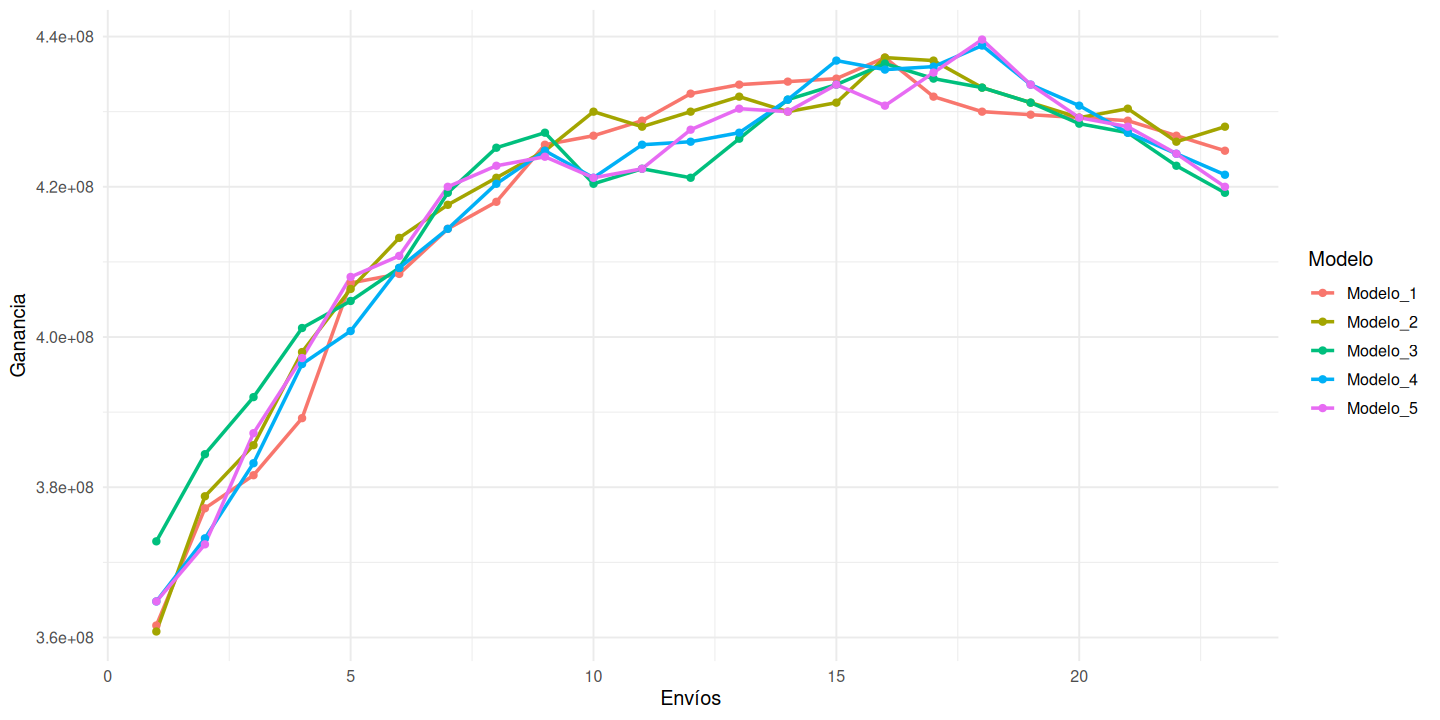

In [43]:
# Grafico las ganancias

library(ggplot2)
options(repr.plot.width = 12, repr.plot.height = 6)
# === 1) Usa tu data.table aquí ===
# Supongamos que se llama 'dt' y que TODAS sus columnas son cantidades de envíos (p.ej. "50","100","150")
# Si además tenés columnas extra (id, fecha, etc.), indicá cuáles son de envíos en 'cols_envios' manualmente.
dt <- as.data.table(mganancias)   # <- reemplazá por tu objeto

# Si ya tenés una columna con el nombre del modelo, usala en lugar de esto.
dt[, modelo := paste0("Modelo_", .I)]

# === 2) Identificar columnas de envíos ===
# Caso A: todas las columnas (excepto 'modelo') son de envíos:
cols_envios <- setdiff(names(dt), "modelo")

# (Opcional) Si tus nombres tienen prefijos tipo "envios_100", "k_050", etc.,
# igual los vamos a parsear más abajo.

# === 3) Ancho -> Largo ===
long <- melt(
  dt,
  id.vars = "modelo",
  measure.vars = cols_envios,
  variable.name = "envios_col",
  value.name = "ganancia"
)

# === 4) Extraer el número de envíos desde el nombre de columna ===
# - Si las columnas son "50","100","150": as.numeric(envios_col) alcanza.
# - Si tienen texto (p.ej. "envios_100"): usamos gsub para quedarnos con los dígitos.
long[, envios := suppressWarnings(as.numeric(as.character(envios_col)))]
idx_na <- is.na(long$envios)
if (any(idx_na)) {
  long[idx_na, envios := as.numeric(gsub("[^0-9\\.]+", "", envios_col))]
}

# Orden por modelo y envíos
setorder(long, modelo, envios)

# === 5) Plot: una curva por modelo ===
p <- ggplot(long, aes(x = envios, y = ganancia, color = modelo, group = modelo)) +
      geom_line(linewidth = 1) +
      geom_point() +
      labs(x = "Envíos", y = "Ganancia", color = "Modelo") +
      theme_minimal(base_size = 12)

print(p)

# Guardo el gif
ggsave("./grafico_ganancia.png", plot = p, width = 8, height = 5, dpi = 300)

In [44]:
icerca <- which.min(  abs( tb_prediccion$gan_acum - mcorte_mejor ) )
vmodelo <- tb_prediccion[ icerca, meta_modelo ]
tb_pred <- tb_prediccion[meta_modelo==vmodelo]

mcorte_mejor
icerca
tb_prediccion[ icerca]

ERROR: Error: object 'tb_prediccion' not found


In [ ]:
icerca <- which.min(  abs( tb_pred$gan_acum - mcorte_mejor ) )
icerca